In [1]:
import pandas as pd
import numpy as np
import wfdb
from scipy.io import loadmat
import glob
import os
import collections
from shutil import copyfileobj
from tqdm import tqdm
import joblib
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import warnings; warnings.filterwarnings('ignore')

In [2]:
SNOMED_CODES = {
    '426783006': 'NORM', #1752
    '164889003': 'AF', #570
    '270492004': 'IAVB', #769
    '426177001': 'SB', #1677
    '39732003': 'LAD', #940
    '427084000': 'STach', #1261
    '164934002': 'TAb', #2306
    '59931005': 'TInv', #812
    '111975006': 'LQT', #1391
    '284470004': 'PAC', #639
}

CLASSES = ['NORM', 'AF', 'IAVB', 'SB', 'LAD', 'STach', 'TAb', 'TInv', 'LQT', 'PAC']

In [3]:
data_path = './data/original/'

In [4]:
# # remove the .mat in the first line of all headers

# headers = glob.glob(data_path+'*.hea')
# for h in headers:
#     with open(h, 'r') as f:
#         lines = f.readlines()

#     lines[0] = lines[0].replace('.mat', '')

#     with open(h, 'w') as f:
#         f.writelines(lines)        

In [31]:
headers[0]

'./data/original/E01720'

In [6]:
signal, meta = wfdb.rdsamp('./data/original/E01720')

signal.shape

(5000, 12)

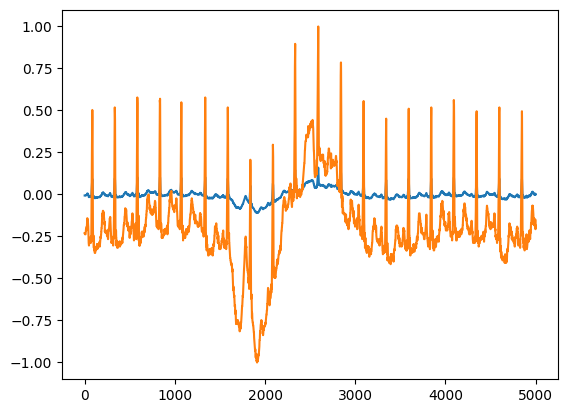

In [15]:
plt.plot(signal[:, 0])
scaler = MinMaxScaler((-1, 1))

plt.plot(scaler.fit_transform(signal)[:, 0])

In [ ]:
# headers = glob.glob(data_path+'*.hea')
# headers = [h[:-4] for h in headers] # remove extensions
# unique_labels = collections.defaultdict(int)

# for f in headers:
#     signal, meta = wfdb.rdsamp(f)

#     # Label
#     l = meta['comments'][2]
#     for sc in l[4:].split(','):
#         unique_labels[sc] += 1

# unique_labels = {k:v for k, v in sorted(unique_labels.items(), key = lambda i: i[1], reverse=True)}
# unique_labels

In [45]:
# # headers = glob.glob(data_path+'*.hea')
# # headers = [h[:-4] for h in headers] # remove extensions
# length = []
# for f in headers:
#     signal, meta = wfdb.rdsamp(f)
#     length.append(len(signal))

# len(length)

10344

In [11]:
def downsample(signal, ratio=5):
    # Signal of size (L, 12) to (L/ratio, 12)
    return signal[::ratio, :]

In [12]:
LENGTH = 1000
def crop(signal):
    return signal[0:LENGTH, :]

In [13]:
def load_raw_data(path):
    headers = glob.glob(path+'*.hea')
    headers = [h[:-4] for h in headers] # remove extensions
    data = []
    labels = []
    scaler = MinMaxScaler((-1, 1))
    
    for f in tqdm(headers):
        signal, meta = wfdb.rdsamp(f)
        
        # Signal
        downsampled = downsample(signal)
        l = downsampled.shape[0]
        if l < LENGTH: # drop 6 signals of length < 1000
            continue
        elif l > LENGTH:
            downsampled = crop(downsampled)
            l = len(downsampled)
            assert l == LENGTH
        
        # Min-max scaling
        scaled = scaler.fit_transform(downsampled)
        
        data.append(scaled)
        
        # Label
        l = meta['comments'][2]
        assert l.startswith('Dx:') and l[3] == ' '
        lb = [0] * len(CLASSES)
        # Set one-hot values for diagnosed labels
        for sc in l[4:].split(','):
            if sc not in SNOMED_CODES:
                continue
            val = SNOMED_CODES[sc]
            idx = CLASSES.index(val)
            lb[idx] = 1
            
        labels.append(lb)
        
    assert len(data) == len(labels)
    return np.array(data), np.array(labels)


In [14]:
X, y = load_raw_data(data_path)

100%|█████████████████████████████████████████████████████████████████████████████████████████████| 10344/10344 [00:28<00:00, 363.64it/s]


### Split 

In [19]:
X.shape, y.shape

((10292, 1000, 12), (10292, 10))

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=1)

In [21]:
y_train.sum(axis=0)/len(y_train)

array([0.17171864, 0.05815809, 0.07382161, 0.16113125, 0.09079043,
       0.11921682, 0.22480058, 0.08092821, 0.13604061, 0.06192893])

In [22]:
y_test.sum(axis=0)/len(y_test)

array([0.16220194, 0.04916102, 0.07565499, 0.16396821, 0.09184575,
       0.12923168, 0.22048867, 0.07359435, 0.13099794, 0.06152487])

In [23]:
X_train.shape

(6895, 1000, 12)

In [24]:
y_train[0].shape

(10,)

In [26]:
# X_test = joblib.load('./data/X_test.joblib')
np.isnan(X_test).any()

True

In [27]:
# X_train = joblib.load('./data/X_train.joblib')
np.isnan(X_train).any()

True

In [28]:
nan_idx_train = np.argwhere(np.isnan(X_train))
nan_idx_train

array([[ 289,  250,    0],
       [ 289,  250,    1],
       [ 289,  403,    0],
       [ 289,  403,    1],
       [ 289,  648,    0],
       [ 289,  648,    1],
       [ 289,  828,    0],
       [ 289,  828,    1],
       [ 488,    0,    8],
       [ 488,    1,    8],
       [ 623,  908,   11],
       [4223,   42,    7],
       [4430,  746,    7],
       [4430,  746,    8],
       [4430,  747,    8]])

In [29]:
nan_idx_test = np.argwhere(np.isnan(X_test))
nan_idx_test

array([[2309,  358,   11]])

In [30]:
i, j, k = nan_idx_test[0]
i

2309

In [31]:
def fill_nan(a, nan_idx): # Won't work with adjacent nan
    i, j, k = nan_idx
    if j == 0:    
        a[i, j, k] = a[i, j+1, k]
    elif j == LENGTH-1:
        a[i, j, k] = a[i, j-1, k]
    else:
        a[i, j, k] = (a[i, j+1, k] + a[i, j-1, k]) / 2.0


In [32]:
for idx in nan_idx_train:
    fill_nan(X_train, idx)

for idx in nan_idx_test:
    fill_nan(X_test, idx)

In [33]:
np.argwhere(np.isnan(X_test))

array([], shape=(0, 3), dtype=int64)

In [34]:
np.argwhere(np.isnan(X_train))

array([[ 488,    0,    8],
       [ 488,    1,    8],
       [4430,  746,    8],
       [4430,  747,    8]])

In [35]:
# For the 4 indices above, fill manually

X_train[488,    0,    8] = X_train[488,    2,    8]
X_train[488,    1,    8] = X_train[488,    2,    8]
X_train[4430,  746,    8] = (X_train[4430,  745,    8] + X_train[4430,  748,    8]) /2.0
X_train[4430,  747,    8] = (X_train[4430,  745,    8] + X_train[4430,  748,    8]) /2.0


In [36]:
np.argwhere(np.isnan(X_train))

array([], shape=(0, 3), dtype=int64)

In [38]:
joblib.dump(X_train, './data/X_train.joblib')
joblib.dump(y_train, './data/y_train.joblib')
joblib.dump(X_test, './data/X_test.joblib')
joblib.dump(y_test, './data/y_test.joblib')

['./data/y_test.joblib']

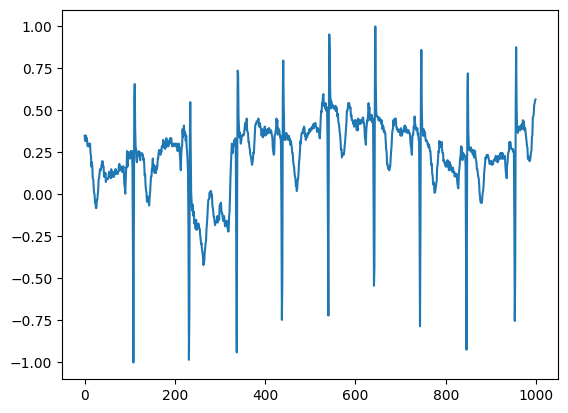

In [39]:
plt.plot(X_test[19, :, 3])

In [2]:
X_train = joblib.load('./data/X_train.joblib')
y_train = joblib.load('./data/y_train.joblib')
X_test = joblib.load('./data/X_test.joblib')
y_test = joblib.load('./data/y_test.joblib')
X_full = np.concatenate((X_train, X_test))
y_full = np.concatenate((y_train, y_test))
X_full.shape, y_full.shape

((10292, 1000, 12), (10292, 10))

In [3]:
joblib.dump(X_full, './data/X_full.joblib')
joblib.dump(y_full, './data/y_full.joblib')

['./data/y_full.joblib']